In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# Summary:
**This notebook is a comprehensive machine learning project aimed at predicting system threats using various classification algorithms. The dataset used is from the "System Threat Forecaster" competition on Kaggle. Here's a summary of the notebook:**

**1. Import necessary libraries and load the data: The notebook starts by importing libraries such as pandas, numpy, matplotlib, seaborn, sklearn, and others. It then loads the training and test datasets from the provided CSV files.**

**2. Exploratory Data Analysis (EDA): The notebook performs exploratory data analysis to understand the dataset's characteristics, identify missing values, and visualize the data. It generates histograms, correlation heatmaps, and other plots to gain insights into the data.**

**3. Preprocessing: The notebook handles missing values and categorical data by filling them with the most frequent value (mode) for categorical features and the median value for numerical features. It applies label encoding to categorical features and standardizes numerical features.**

**4. Model Training: The notebook compares the performance of four different classification algorithms: Gradient Boosting, Random Forest, LightGBM, and XGBoost. It trains each model on the preprocessed data and evaluates their performance using accuracy and classification reports.**

**5. Hyperparameter Tuning: The notebook optimizes the hyperparameters of the LightGBM model using RandomizedSearchCV to improve its performance. It defines a hyperparameter grid and performs a randomized search to find the best combination of hyperparameters.**

**6. Submission Result: The notebook selects the tuned LightGBM model as the final model and generates predictions for the test dataset. It saves the predictions in a CSV file and prints a summary of the final result.**

**Overall, this notebook provides a comprehensive analysis of the dataset, implements various machine learning algorithms, optimizes hyperparameters, and generates a submission file for the Kaggle competition.**.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing and modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Models to compare
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb

# Metrics
from sklearn.metrics import accuracy_score, classification_report

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')
random_state=5

# 1. Load the Data

In [3]:


train_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')
sample_submission = pd.read_csv('/kaggle/input/System-Threat-Forecaster/sample_submission.csv')


In [4]:
train_df


,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,a378b2196a7a1d8ee0d4f989ee46730e,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1582.0,0,7.0,0,68585.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-21 00:59:00,2018-09-20,0
99996,7f4433ca05d24b9bbdd3932f8b05e61f,win8defender,1.1.15100.1,4.18.1806.18062,1.273.1156.0,0,7.0,0,11280.0,2.0,...,0,0.0,0,0,0.0,0.0,3.0,2018-08-10 07:23:00,2018-07-10,0
99997,d6852dfff534e03d5ddfd3c7875ab072,win8defender,1.1.15200.1,4.18.1807.18075,1.275.209.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,1.0,1.0,2018-08-26 23:51:00,2018-03-13,1
99998,70a8dc682128c9ff78a3de5aea9dac74,win8defender,1.1.14901.4,4.16.17656.18052,1.269.641.0,0,7.0,0,53447.0,1.0,...,1,0.0,1,1,1.0,0.0,1.0,2018-06-04 17:13:00,2018-05-08,0


In [5]:
train_df.columns

Index(['MachineID', 'ProductName', 'EngineVersion', 'AppVersion',
       'SignatureVersion', 'IsBetaUser', 'RealTimeProtectionState',
       'IsPassiveModeEnabled', 'AntivirusConfigID',
       'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled',
       'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID',
       'PlatformType', 'Processor', 'OSVersion', 'OSBuildNumber',
       'OSProductSuite', 'OsPlatformSubRelease', 'OSBuildLab',
       'SKUEditionName', 'IsSystemProtected', 'AutoSampleSubmissionEnabled',
       'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA',
       'MDC2FormFactor', 'DeviceFamily', 'OEMNameID', 'OEMModelID',
       'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID',
       'PrimaryDiskCapacityMB', 'PrimaryDiskType', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB', 'ChassisType',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutio

# 2. Exploratory Data Analysis (EDA)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

### **This gives insights about the number of rows, columns, data types,missing value and memory usage of train data frame.**

In [7]:

train_df.describe()

,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,...,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,target
count,100000.0,99934.000000,100000.000000,99924.000000,99924.000000,99924.000000,100000.000000,100000.000000,99377.000000,100000.000000,...,99624.000000,99666.000000,100000.000000,99980.000000,100000.000000,100000.000000,99866.000000,99441.000000,99441.000000,100000.000000
mean,0.0,6.848430,0.017620,47975.710440,1.326528,1.018264,0.996780,108.078790,81029.938587,169.741630,...,401.987613,32942.648044,0.495690,0.003841,0.128470,0.040580,0.058398,0.296668,7.875866,0.505250
std,0.0,1.015166,0.131566,13803.321533,0.520681,0.155291,0.056654,63.062151,48944.027074,89.188929,...,221.318891,21151.970827,0.499984,0.061855,0.334614,0.197316,0.234496,0.456791,4.562533,0.499975
min,0.0,0.000000,0.000000,39.000000,1.000000,0.000000,0.000000,1.000000,7.000000,1.000000,...,2.000000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.0,7.000000,0.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,36694.000000,89.000000,...,142.000000,13020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.0,7.000000,0.000000,53447.000000,1.000000,1.000000,1.000000,97.000000,82373.000000,181.000000,...,500.000000,33066.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000
75%,0.0,7.000000,0.000000,53447.000000,2.000000,1.000000,1.000000,162.000000,122835.000000,267.000000,...,556.000000,52357.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,1.000000
max,0.0,8.000000,1.000000,70490.000000,5.000000,4.000000,1.000000,222.000000,167957.000000,296.000000,...,1083.000000,72091.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000


### **It provides statistical summaries of the numeric columns in the DataFrame and helps in understand the distribution, central tendency (mean/median), and range of numeric data.**


In [8]:
train_df.target.value_counts(normalize=True)

target
1    0.50525
0    0.49475
Name: proportion, dtype: float64

In [9]:
train_df.isnull().sum()


MachineID             0
ProductName           0
EngineVersion         0
AppVersion            0
SignatureVersion      0
                   ... 
IsGamer             559
RegionIdentifier    559
DateAS                0
DateOS               24
target                0
Length: 76, dtype: int64


### **Column-wise missing values: Each column's count of missing entries.**
### **Identifies data gaps: Helps you find where data cleaning or imputation is needed.**


## Visualizing

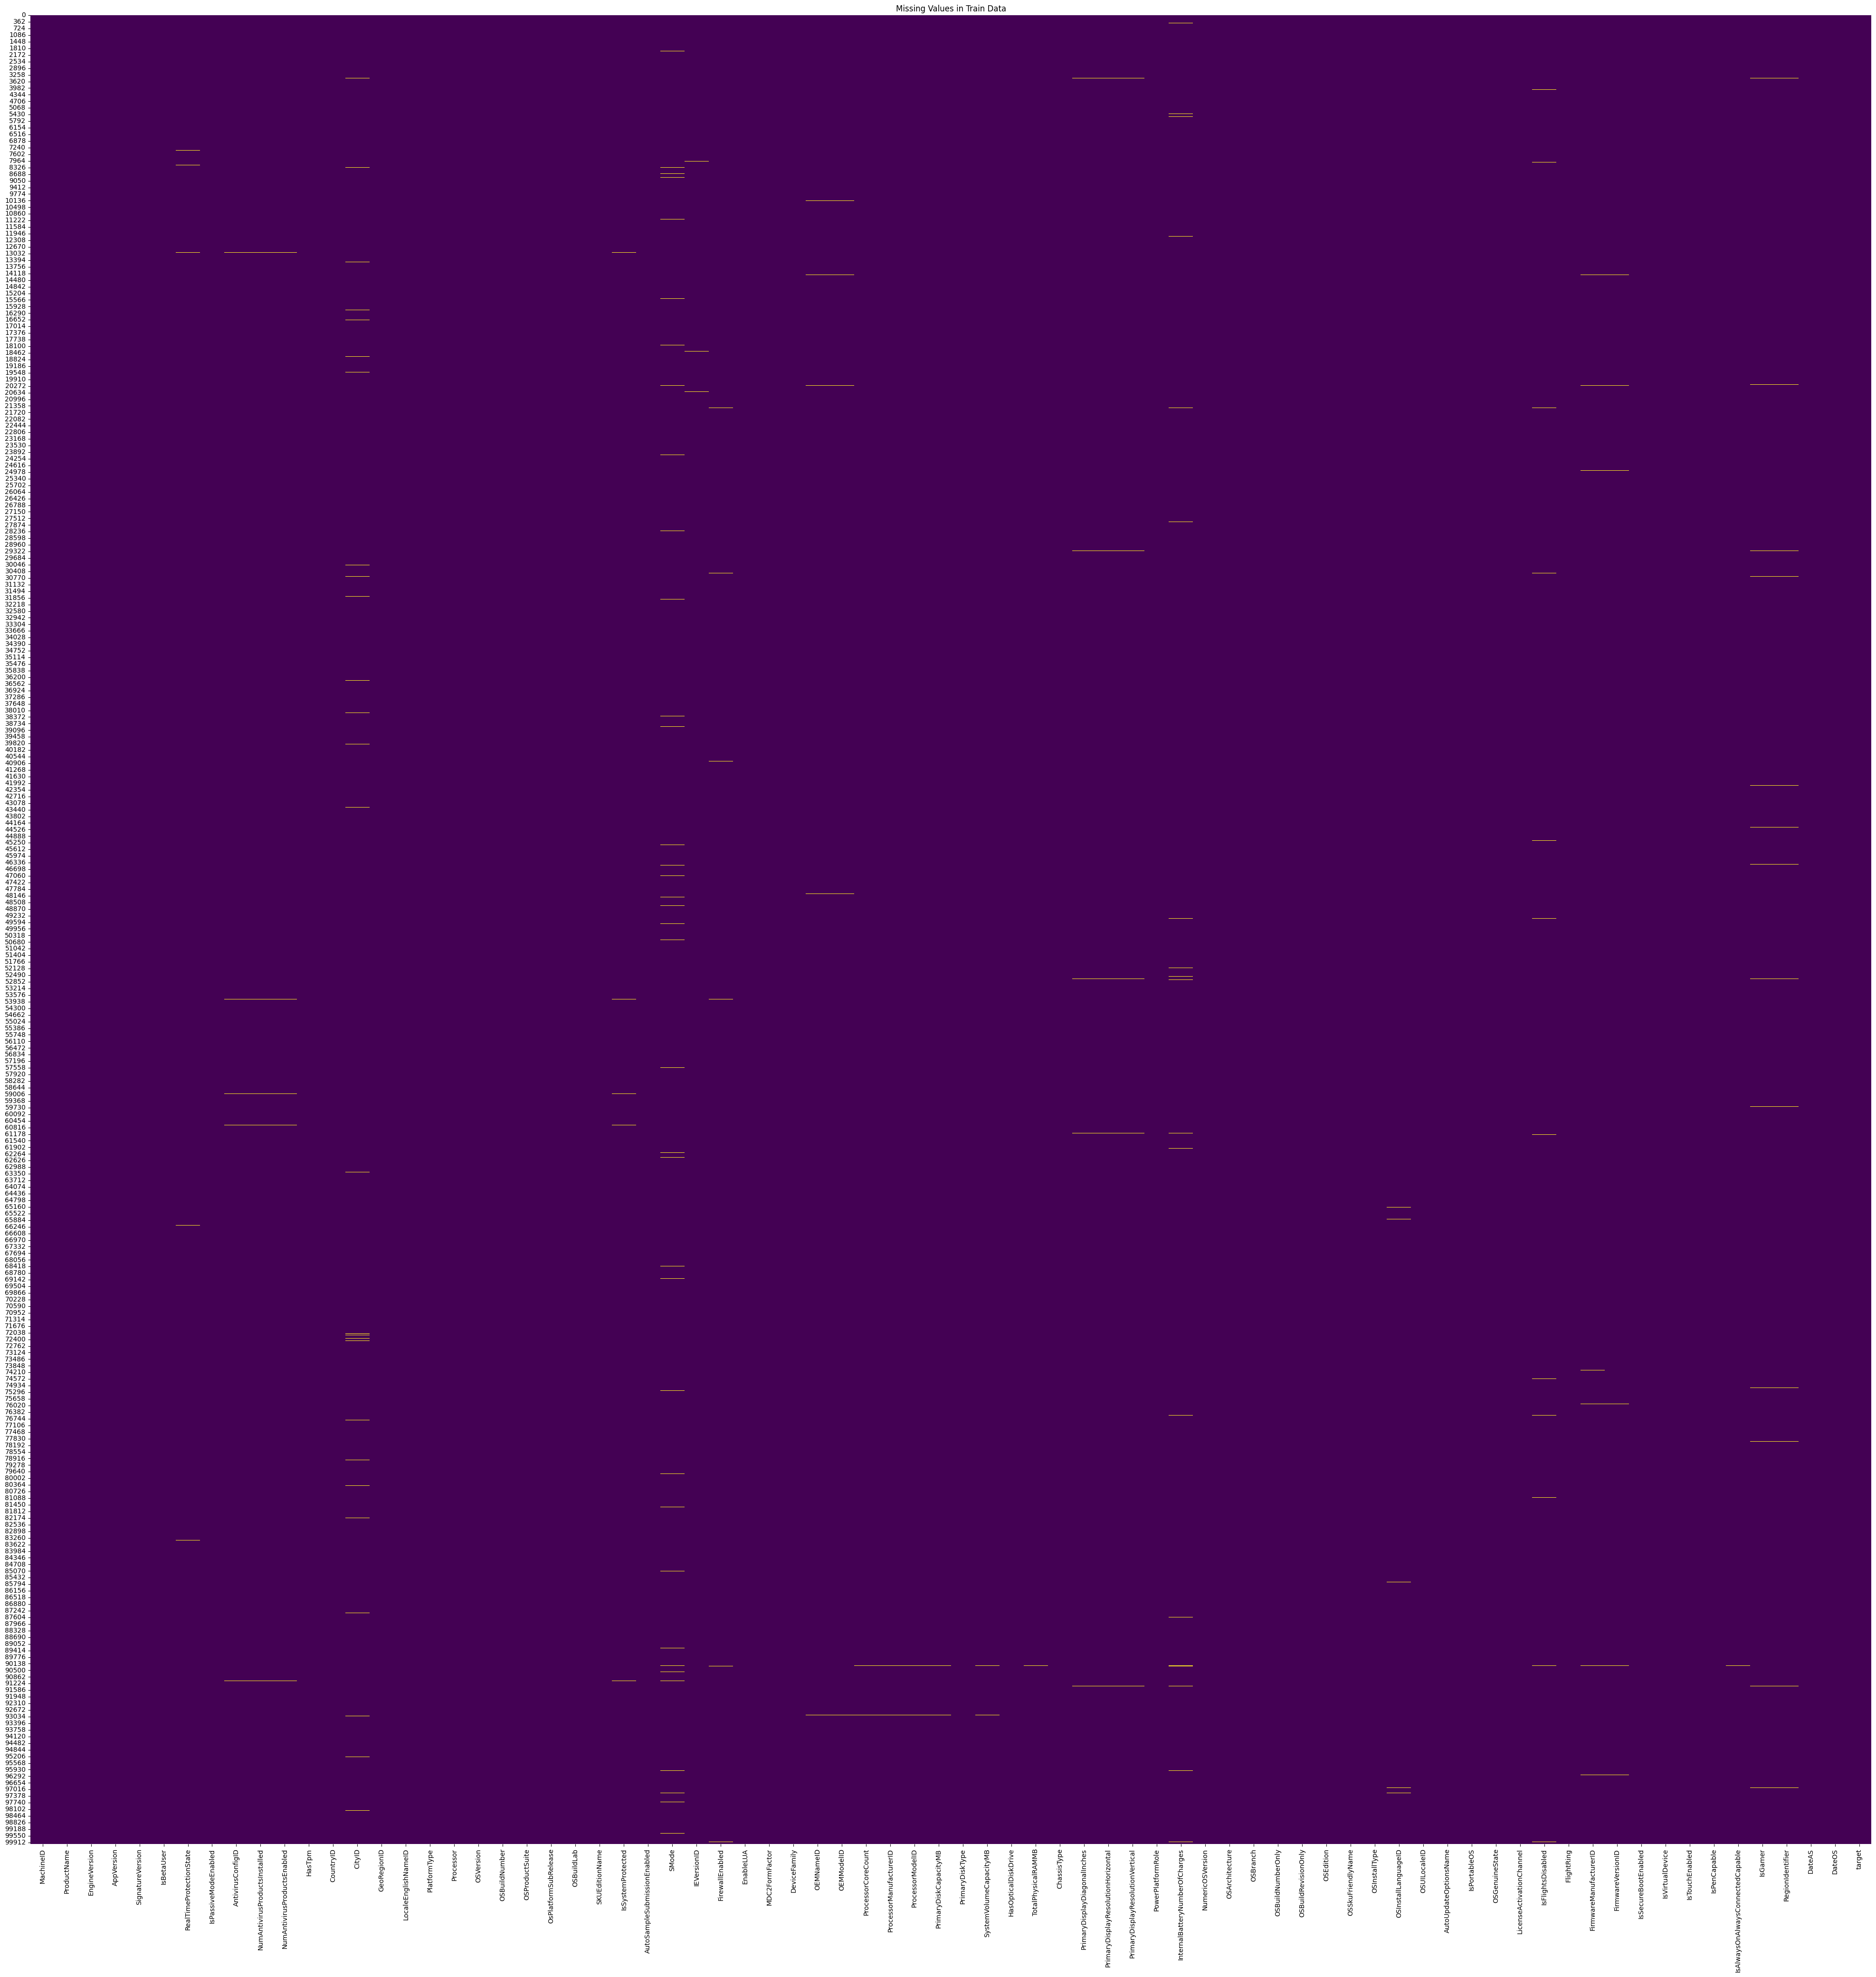

In [10]:
#Missing Values
plt.figure(figsize=(50, 50))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Train Data")
plt.show()


###  **This visualization helps identify patterns in missing data across the dataset. If a column has too many missing values,  may consider dropping it or imputing values.**

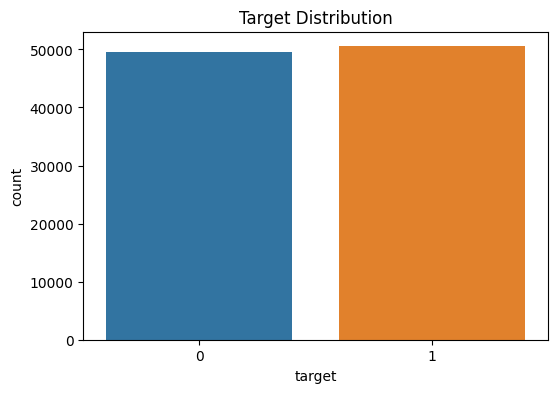

In [11]:
# Visualize target distribution 
if 'target' in train_df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='target', data=train_df)
    plt.title("Target Distribution")
    plt.show()

### This visualization helps in finding the balance of class. Here the bars are almost equal which means class is balanced in target column which is good for training 

## Histogram 

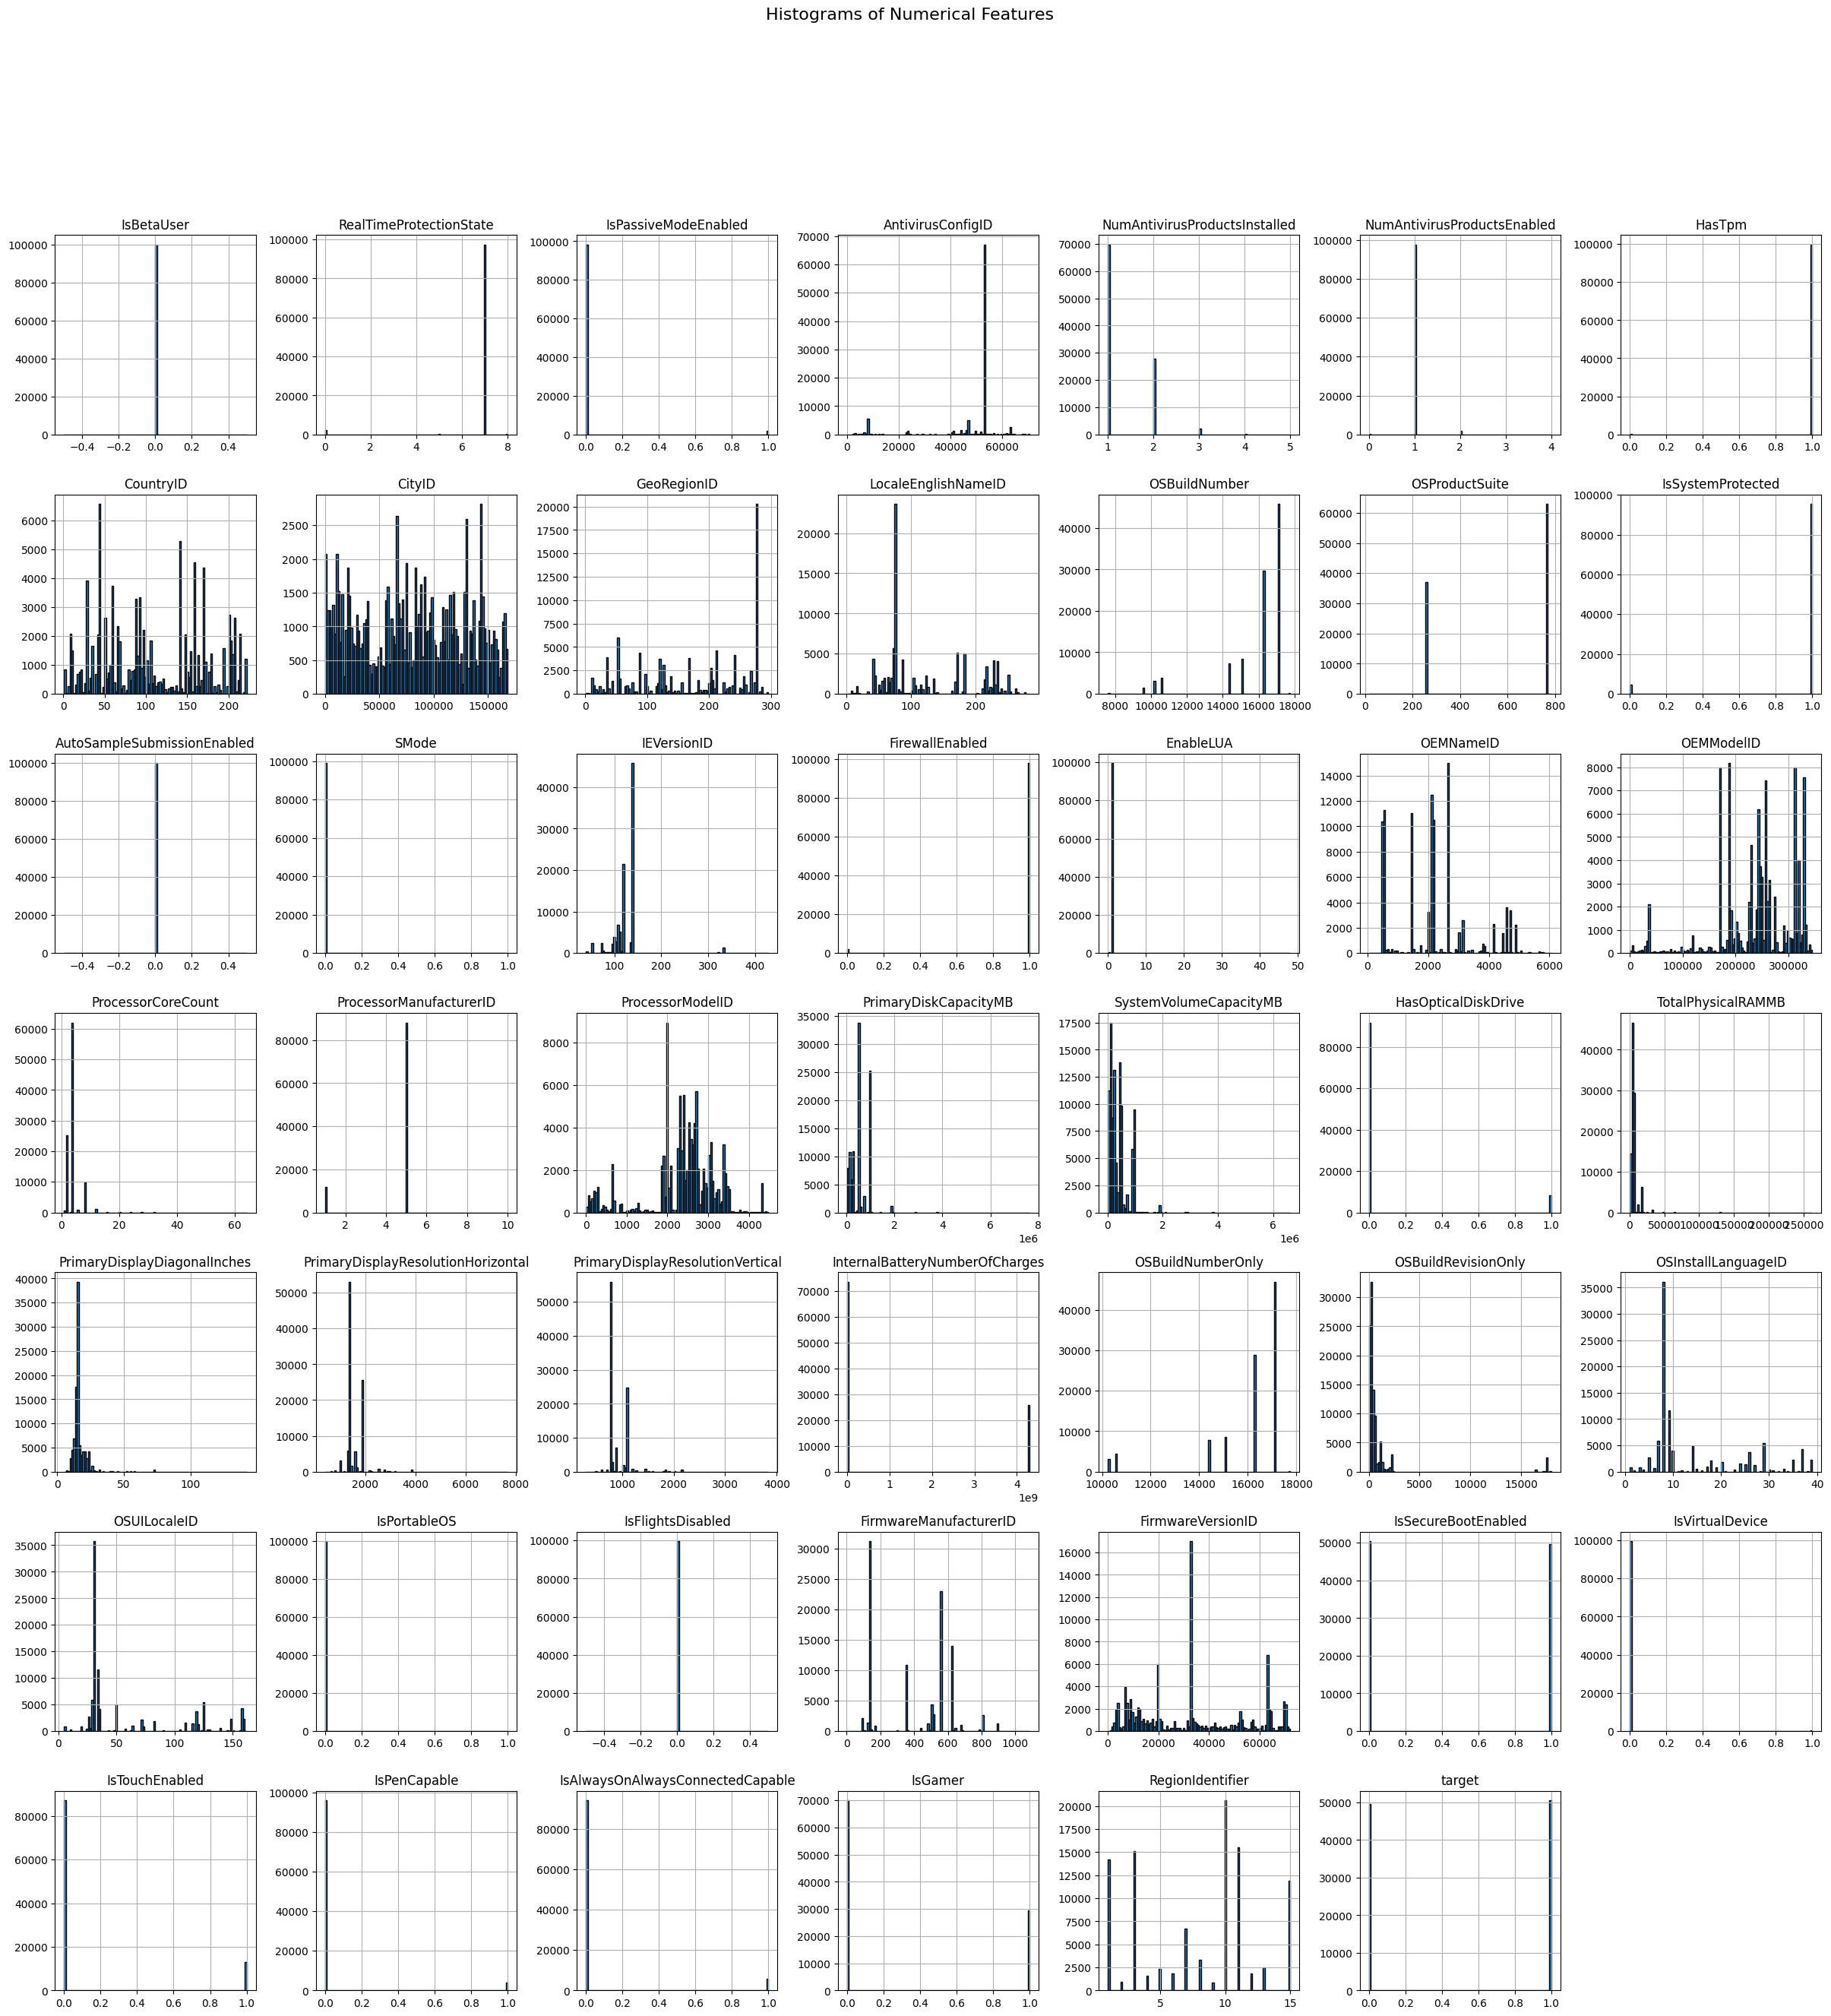

In [12]:

# Select only numerical columns
numerical_columns = train_df.select_dtypes(include=['number']).columns

# Plot histograms
train_df[numerical_columns].hist(figsize=(30, 30), bins=100, edgecolor='black')

plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()


### This visualization of histogram help in understanding the data distribution like Normal or Skewed Distribution. From the visualization the most of features on numerical data are skewed distribution therefore the MinMaxScaling should be done before building the learning model

## Correlation Heatmap

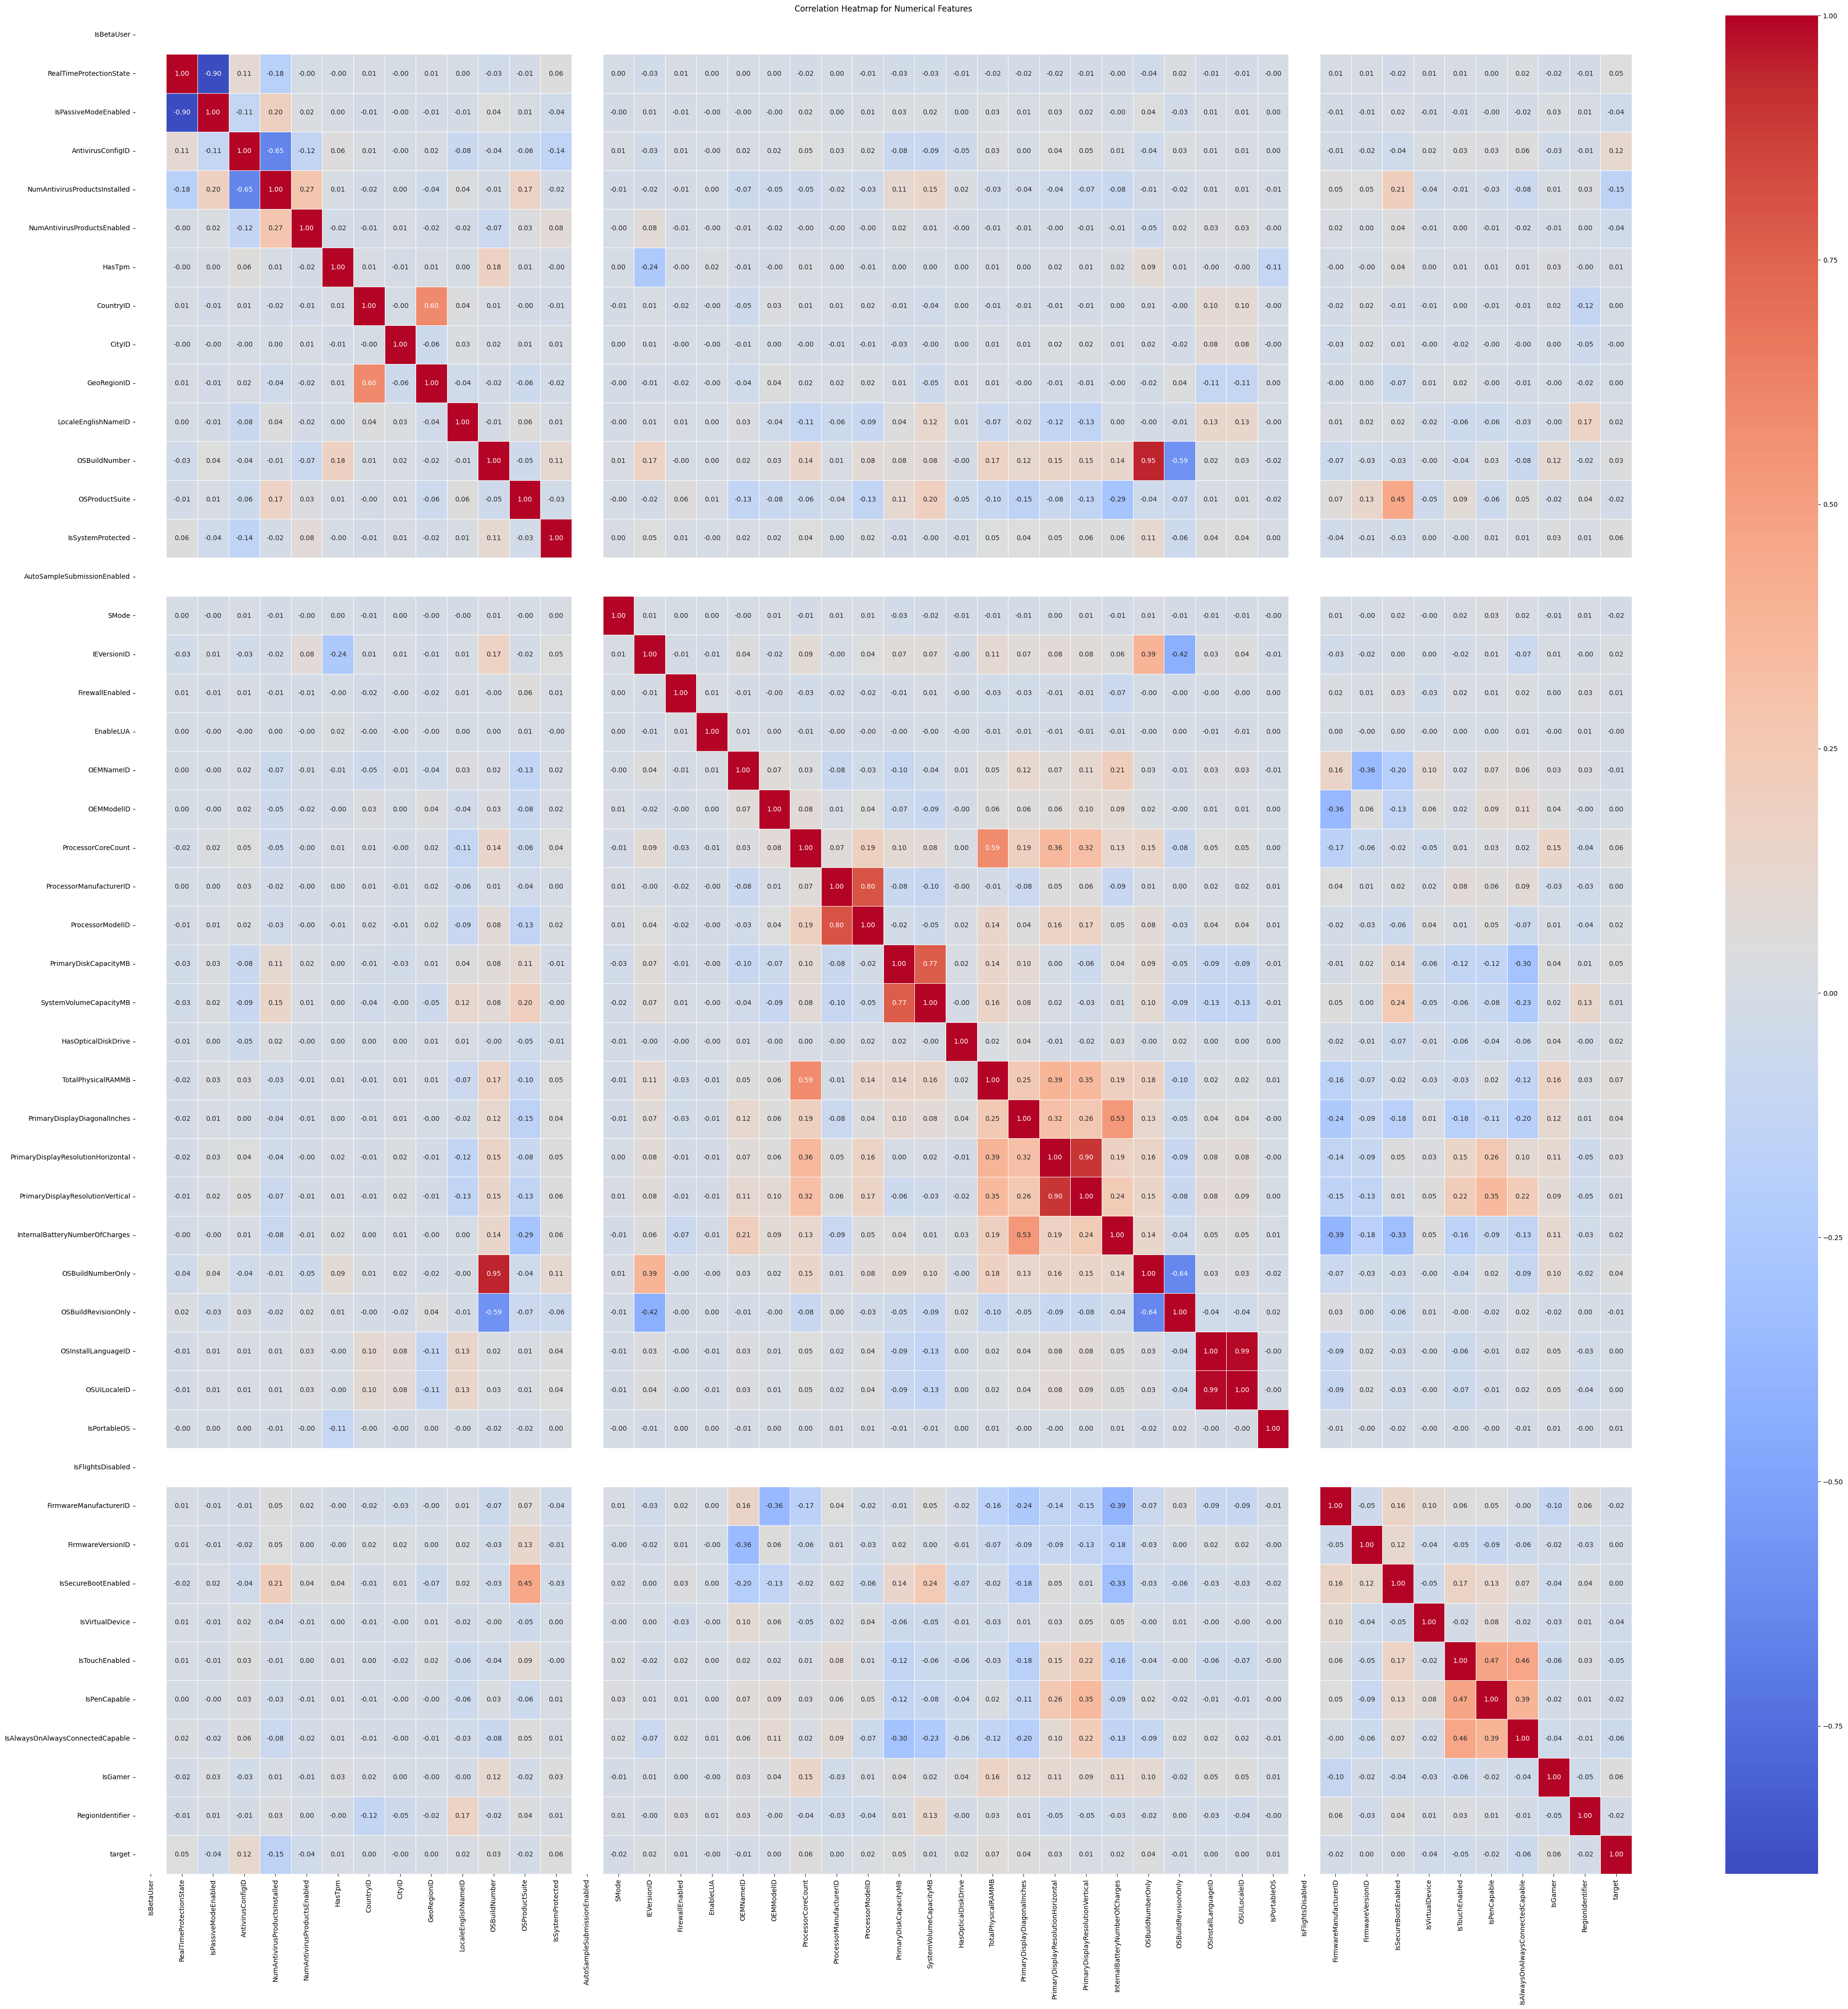

In [13]:


# Select only numerical features
numerical_features = train_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numerical_features.corr()

# Plot heatmap
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Numerical Features")
plt.show()

### Using correlation heatmap can understand feature Relationships like Positive Correlation, Negative Correlation and No Correlation.


In [14]:


# Select only numerical columns
numerical_columns = train_df.select_dtypes(include=['number']).columns

# Compute correlation matrix
correlation_matrix = train_df[numerical_columns].corr().abs()

# Identify correlated features (threshold = 0.8)
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > 0.8:  # Check correlation
            colname = correlation_matrix.columns[i]  # Get column name
            high_corr_features.add(colname)

# Drop highly correlated features
train_df.drop(columns=high_corr_features, inplace=True)

# Print dropped features
print("Dropped features due to high correlation:", high_corr_features)


Dropped features due to high correlation: {'IsPassiveModeEnabled', 'OSUILocaleID', 'PrimaryDisplayResolutionVertical', 'ProcessorModelID', 'OSBuildNumberOnly'}


### Highly correlated features (e.g., above ±0.8) can cause overfitting and should it is removed


# 3. Preprocessing

In [15]:
X= train_df.drop(columns=['target'])
y= train_df['target']


In [16]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Identify Categorical and Numerical Columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# Numerical Transformer (Imputation + Scaling)
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Categorical Transformer (Imputation + Ordinal Encoding)
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Preprocessor (Combining Transformers)
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Transform Data
train = preprocessor.fit_transform(X)
test = preprocessor.transform(test_df)

print(train.shape)
print(test.shape)


(100000, 70)
(10000, 70)


### This preprocessing pipeline is used to prepare raw data for machine learning models by handling missing values, scaling, and encoding.By running this code, we get preprocessed numerical data stored in train and test, which can now be fed into a machine learning model. 

## Split into train and validation sets

In [17]:
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=5) #Split into train and validation sets

### Training Set: Helps the model learn patterns in the data.

### Validation Set: Measures how well the model performs on unseen data to detect overfitting or underfitting.

# 4. Model Training

## Gradient Boosting Classifier

In [18]:

# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=5)

# Train model
gb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_gb = gb_model.predict(X_val)

# Evaluate model
print(f"Gradient Boosting Accuracy: {accuracy_score(y_val, y_pred_gb):.4f}")
print("Gradient Boosting Classification Report:\n", classification_report(y_val, y_pred_gb))


Gradient Boosting Accuracy: 0.6266
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.57      0.60      9929
           1       0.62      0.69      0.65     10071

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.62     20000
weighted avg       0.63      0.63      0.63     20000



## LGBMClassifier

In [19]:
# Initialize LGBMClassifier
lgb_clf = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=7, verbose = -1,random_state=5)

lgb_clf.fit(X_train, y_train)  

y_pred_lb= lgb_clf.predict(X_val)


# Evaluate model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_lb))
print("Classification Report:\n", classification_report(y_val, y_pred_lb))



Validation Accuracy: 0.6305
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.59      0.61      9929
           1       0.62      0.67      0.65     10071

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



## XGBClassifier

In [20]:

# Initialize XGBClassifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=200, 
    max_depth=7, 
    learning_rate=0.1, 
    colsample_bytree=1.0, 
    subsample=1.0,
    num_leaves=40, 
    random_state=5
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred_xg = xgb_clf.predict(X_val)
# Evaluate model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_xg))
print("Classification Report:\n", classification_report(y_val, y_pred_xg))


Validation Accuracy: 0.62855
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.59      0.61      9929
           1       0.62      0.67      0.64     10071

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



## RandomForestClassifier

In [21]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10,
random_state=5)

# Train model
rf_model.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf_model.predict(X_val)

# Evaluate model
print(f"Random Forest Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print("Random Forest Classification Report:\n",classification_report(y_val, y_pred_rf))


Random Forest Accuracy: 0.6161
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.51      0.57      9929
           1       0.60      0.72      0.65     10071

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.61     20000
weighted avg       0.62      0.62      0.61     20000



### By training and evaluating four different machine learning models (Gradient Boosting, LightGBM, XGBoost, and Random Forest) and  comparing four models validation  accuracy LightGBM is better.  It suggests LightGBM's ability to handle large datasets efficiently works well.

# 5. Hyperparameter Tuning

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

# Define the parameter grid for Random Search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],    #Controls how quickly the model adapts to patterns 
    'max_depth': [5, 7, 10],               #Maximum depth of the decision trees.
    'num_leaves': [30, 40, 50],            #Maximum number of leaf nodes 
    'min_child_samples': [20, 30, 50],     #Minimum number of data samples required in a leaf node.
    'subsample': [0.6, 0.8, 1.0],          #Fraction of training data used for building each tree
    'colsample_bytree': [0.6, 0.8, 1.0],   #Fraction of features used for building each tree
    'reg_alpha': [0.01, 0.1, 1],           # Adds a penalty for the absolute value of leaf weights.
    'reg_lambda': [0.01, 0.1, 1],          # Adds a penalty for the Squared value of leaf weights.
    'n_estimators': [200, 300, 500]        #Number of boosting rounds (trees) to build.

}

# Initialize the LightGBM model
lgbm = LGBMClassifier(random_state=5)

# Set up RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=10,            # Number of random combinations to try
    scoring='accuracy',   # Metric for evaluation
    cv=5,                 # 5-fold cross-validation
    verbose=2,            # Print progress
    n_jobs=-1,            # Use all available CPU cores
    random_state=5       # For reproducibility
)

# Fit the model on training data
random_search.fit(X_train, y_train)

# Retrieve the best model
best_lgbm = random_search.best_estimator_

# Output the best hyperparameters
print("Best Params:", random_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 1, 'num_leaves': 40, 'n_estimators': 300, 'min_child_samples': 20, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


### By performing Hyper parametertuning get

### Best Hyperparameters: Outputs the most optimized parameters for LightGBM.

### Improved Performance: Tuning often improves accuracy and reduces overfitting.

### Model Ready for Testing: The best_lgbm model can be used for predictions and evaluation.



## Tuned LGBMclassifier

In [23]:


# Make predictions
y_pred_lgbm = best_lgbm.predict(X_val)

# Predict on test set
lgb_predictions = best_lgbm.predict(test)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_lgbm))
print("Classification Report:\n", classification_report(y_val, y_pred_lgbm))


Validation Accuracy: 0.63085
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.59      0.61      9929
           1       0.62      0.67      0.65     10071

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000




### The tuned LightGBM improves accuracy compared to previous models.  
### The retrived model gives prediction on test data


# 6. Submission Result

In [24]:
submission = pd.DataFrame({'id': range(len(lgb_predictions)), 'target':lgb_predictions})
submission.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created successfully.")


Submission file 'submission.csv' created successfully.


In [25]:
final_result =pd.read_csv('/kaggle/working/submission.csv')
final_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      10000 non-null  int64
 1   target  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [26]:
final_result.head()

,id,target
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0


### Predicted outputs on test data is submitted